In [32]:
import numpy as np

In [33]:
pi = RR.pi()

def integrate_curvature(kappa, s, srange=(0,1), theta_0=0, x_0=0, y_0=0, step=0.1):
    theta, x, y = var('θ, x, y')
    DE0 = kappa
    DE1 = cos(theta)
    DE2 = sin(theta)
    ICs = [srange[0], theta_0, x_0, y_0]

    P = desolve_system_rk4([DE0, DE1, DE2], [theta, x, y], ics=ICs, ivar=s, end_points=srange[1], step=step)
    return P


def splines_from_curvature(kappa, s, srange=(0,1), theta_0=0, x_0=0, y_0=0, step=0.1):
    P = integrate_curvature(kappa, s, srange, theta_0, x_0, y_0, step)

    x_spline = spline([(s, x) for s, theta, x, y in P])
    y_spline = spline([(s, y) for s, theta, x, y in P])

    return (x_spline, y_spline)


def spline_avg(f):
    a = f.list()[0][0]
    b = f.list()[-1][0]
    return f.definite_integral(a, b) / (b - a)


def splines_to_angular_momentum(x_0, y_0, x_1, y_1, dt, srange=(0,1), center=(0,0)):
    def theta(a, b): return arccos(a.inner_product(b) / (a.norm() * b.norm()))
    def v_x(z): return (x_0(z) - x_1(z)) / dt
    def v_y(z): return (y_0(z) - y_1(z)) / dt
    def v(z): return vector([v_x(z), v_y(z)])
    def r(z): return sqrt((x_0(z) - center[0])^2 + (y_0(z) - center[1])^2)
    def w(z): return v(z).norm() * sin(theta(v(z), vector([x_0(z) - center[0], y_0(z) - center[1]]))) # |v| * sin(theta)
    integrand = lambda z: w(z) * r(z) # w * r
    angular_momentum = numerical_integral(integrand, srange[0], srange[1])[0] # int_S w * r^2 ds
    return angular_momentum


def splines_to_moment(x, y, srange=(0,1), center=(0,0)):
    return numerical_integral(lambda z: ((x(z) - center[0])^2 + (y(z) - center[1])^2), srange[0], srange[1])[0]


def translate_spline(f, dy):
    return spline([(x, y + dy) for x, y in f.list()])


def rotate_splines(x, y, theta):
    x_list = x.list()
    y_list = y.list()
    
    R = matrix([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    
    completed_x_list = [(s, x, y(s)) for s, x in x_list]
    completed_y_list = [(s, x(s), y) for s, y in y_list]
    
    rotated_x_spline = spline([(s, (R*vector([x, y]))[0]) for s, x, y in completed_x_list])
    rotated_y_spline = spline([(s, (R*vector([x, y]))[1]) for s, x, y in completed_y_list])
    
    return (rotated_x_spline, rotated_y_spline)


def splines_fix_center(x, y, center=(0,0)):
    x_bar = spline_avg(x)
    y_bar = spline_avg(y)
    return (translate_spline(x, -x_bar + center[0]), translate_spline(y, -y_bar + center[1]))

def splines_from_curvature_fix_center(kappa, s, srange=(0,1), theta_0=0, center=(0,0), step=0.1):
    x, y = splines_from_curvature(kappa, s, srange, theta_0, 0, 0, step)
    return splines_fix_center(x, y, center)


def flow_curvature(kappa, srange, arange, acount, theta_0=0, center=(0,0), step=0.1):
    splines = []
    rotated_splines = []
    space, dt = np.linspace(arange[0], arange[1], acount, retstep=True)
    total_counterrotation = 0
    curves = []
    for a in space:
        print(f"Calculating curve for a = {a}...")
        x, y = splines_from_curvature_fix_center(kappa(s, a), s, srange=srange, theta_0=theta_0, center=center, step=step)
        # print(x.list())
        # print(y.list())
        print("Done with curvature integration.")

        if len(splines) >= 1:
            print("Calculating angular momentum...")
            angular_momentum = splines_to_angular_momentum(splines[-1][0], splines[-1][1], x, y, dt, srange=srange, center=center)
            print("Done with angular momentum.")
            print("Calculating moment...")
            I = splines_to_moment(x, y, srange=srange, center=center)
            print("Done with moment.")
            print(f"I = {I}")
            angular_velocity = angular_momentum / I
            dtheta = angular_velocity * dt
            total_counterrotation += dtheta
            print(f"dtheta: {dtheta}\n")
            
        rotated_x, rotated_y = rotate_splines(x, y, total_counterrotation)
        rotated_translated_x, rotated_translated_y = splines_fix_center(rotated_x, rotated_y, center)
        rotated_splines.append((rotated_translated_x, rotated_translated_y))
        splines.append((x, y))
        
    return splines, rotated_splines

In [34]:
def metric_surf_rev_numerical(phi, psi):
    def g(u, v):
        X_u = vector([-phi(v)*sin(u), phi(v)*cos(u), 0])
        X_v = vector([phi.derivative(v)*cos(u), phi.derivative(v)*sin(u), psi.derivative(v)])
        E = X_u.dot_product(X_u)
        G = X_v.dot_product(X_v)
        return matrix([[E, 0], [0, G]])
    return g


def sample_metric_eigenvals(g, urange=(-1, 1), vrange=(-1, 1), ucount=5, vcount=5, sq_len=0.2):
    def angle(a, b):
        return arccos(a.inner_product(b) / (a.norm() * b.norm())) if a.norm() * b.norm() != 0 else 0
    
    squares = []
    transformed_squares = []
    ellipses = []

    uspace = np.linspace(urange[0], urange[1], ucount)
    vspace = np.linspace(vrange[0], vrange[1], vcount)
    space = cartesian_product_iterator([uspace, vspace])
    for u, v in space:
        g_curr = g(u, v)
        eigenvectors = g_curr.eigenvectors_right()
        eigvec = eigenvectors[0][1][0]
        k1 = eigenvectors[0][0]
        if eigenvectors[0][2] == 2:
            k2 = k1
        else:
            k2 = eigenvectors[1][0]
        
        square = matrix([[0, -sq_len/2, 0, sq_len/2], [-sq_len/2, 0, sq_len/2, 0]])
        cross = vector([eigvec[0], eigvec[1], 0]).cross_product(vector([1, 0, 0]))
        theta = arctan2(cross[2], eigvec.dot_product(vector([1, 0])))
        R = matrix([[cos(theta), sin(theta)], [-sin(theta), cos(theta)]])
        
        translate = matrix([[u, u, u, u], [v, v, v, v]])
        transformed = g_curr * R * square
        
        squares.append((R * square) + translate)
        transformed_squares.append(transformed + translate)
        ellipses.append((u, v, k1*sq_len/2, k2*sq_len/2, -theta))

    return squares, transformed_squares, ellipses

In [35]:
def curvature_surf_rev_numerical(phi):    
    def K(u, v):
        dphi = phi.derivative(v)
        d2phi = phi.derivative(v, order=2)
        dpsi = psi.derivative(v)
        d2psi = psi.derivative(v, order=2)
        
#         Go back to using formula with parametrization by arc length
        numerator = (-dpsi**2 * d2phi) + (dphi * dpsi * d2psi)
        denominator = phi(v) * (dphi**2 + dpsi**2)**2
        
        
        return numerator / denominator
    
    def k1(u, v):
        return 1 / phi(v)
    
    def k2(u, v):
        return K(u, v) / k1(u, v)
    
    return k1, k2, K

In [36]:
def reparametrize_by_arclength(x, y, *splines, t0=None, tf=None, dt=0.001, ds=0.1):
    if t0 is None:
        t0 = x.list()[0][0]
    if tf is None:
        tf = x.list()[-1][0]
        
    t_prev = t0 
    t = dt
    
    step_dist = 0
    total_dist = 0
    
    x_list = [(t0, x(t0))]
    y_list = [(t0, y(t0))]
    splines_lists = []
    for i in range(len(splines)):
        splines_list.append([])
    
    def reparametrize_step():
        x_list.append((total_dist, x(t)))
        y_list.append((total_dist, y(t)))
        for i, spline_list in enumerate(splines_lists):
            spline_list.append((total_dist, splines[i](t)))
    
    while t <= tf:
        x_diff = x(t) - x(t_prev)
        y_diff = y(t) - y(t_prev)
        
        dist = sqrt(x_diff**2 + y_diff**2)
        step_dist += dist
        total_dist += dist
        
        if step_dist >= ds:
            reparametrize_step()
            step_dist = 0
        
        t_prev = t
        t += dt
    
    if total_dist > x.list()[-1][0]:
        t = t_prev
        reparametrize_step()
    
    new_x_spline = spline(x_list)
    new_y_spline = spline(y_list)
    new_splines = map(lambda spline_list: spline(spline_list), splines_lists)
    
    if len(splines_lists) > 0:
        return new_x_spline, new_y_spline, new_splines
    else:
        return new_x_spline, new_y_spline

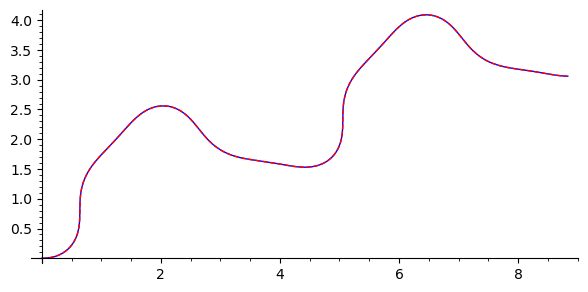

In [37]:
# x = spline([(0, 1), (1, 2), (4, 5), (5, 3)])
# y = spline([(0, 2), (1, 4), (4, 5), (5, 3)])
srange=(0, 4*RR.pi())
kappa(s) = sin(3*s)+cos(s)
x, y = splines_from_curvature(kappa, s, srange, step=0.01)
xs, ys = reparametrize_by_arclength(x, y, ds=0.02)
plot1 = parametric_plot((x, y), srange, color='blue')
plot2 = parametric_plot((xs, ys), (xs.list()[0][0], xs.list()[-1][0]), color='red', linestyle='--')
show(plot1 + plot2)

In [214]:
def xy_splines_from_hm(h, m, srange=(0, pi), step_size=0.1, eps=0.01):
    def y(rho):
        if m(rho) < 0:
            print(f"negative: {rho}, {m(rho)}")
        return sqrt(m(rho))
    
    rho_space = np.linspace(srange[0], srange[1], round((srange[1] - srange[0]) / step_size))
    y_spline = spline([(rho, y(rho)) for rho in rho_space])
    
    def x(rho):
        return numerical_integral(lambda s: sqrt(h(s) - (y_spline.derivative(s))**2), eps, rho)[0]
    
    x_spline = spline([(rho, x(rho)) for rho in rho_space])
    
    return x_spline, y_spline

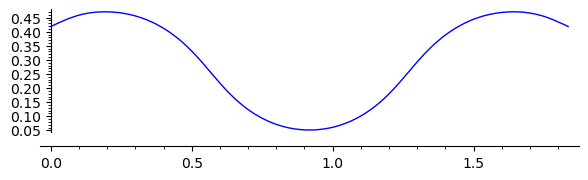

In [254]:
def to_spline(f, srange=(0, pi), step_size=0.01):
    return spline([(s, f(s)) for s in np.linspace(srange[0], srange[1], round((srange[1] - srange[0]) / step_size))])

# c3 = 0.021
# c5 = 0.598
c3 = 0.766
c5 = -0.091
h(rho) = 1
m(rho) = 0.0001 + ((sin(rho) + c3*sin(3*rho) + c5*sin(5*rho))/(1 + 3*c3 + 5*c5))**2

eps = 0.5

srange=(eps, pi-eps)
h = to_spline(h, srange)
m = to_spline(m, srange)


x, y = xy_splines_from_hm(h, m, srange, eps=eps)

parametric_plot((x, y), (x.list()[0][0], x.list()[-1][0]))

In [255]:
def hm_to_ricci_tensor(h, m, return_K=False):
    sqrt_m = spline([(rho, sqrt(m_rho_)) for rho, m_rho_ in m])
    
    def K(rho):
#         print(f"rho: {rho}, K: {sqrt_m.derivative(rho, order=2) / sqrt_m(rho)}")
        return -sqrt_m.derivative(rho, order=2) / sqrt_m(rho)
    
    def R(rho):
        R11 = K(rho) + ((m.derivative(rho) * h.derivative(rho)) / (4 * m(rho) * h(rho)))
        R22 = R11 / (m(rho) * h(rho))
        return matrix([[R11, 0], [0, R22]])
    return R if not return_K else (R, K)

In [256]:
R, K = hm_to_ricci_tensor(h, m, return_K=True)

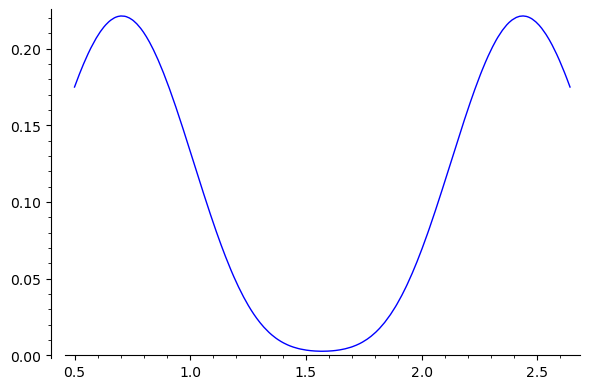

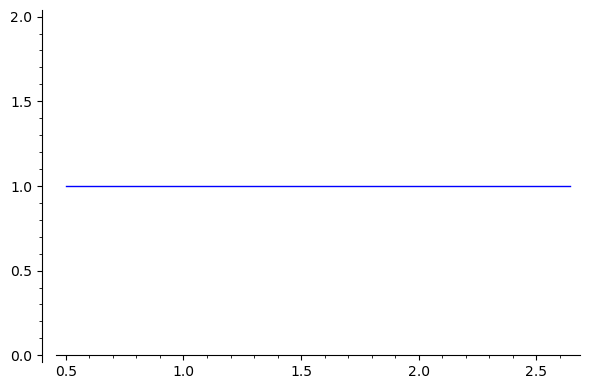

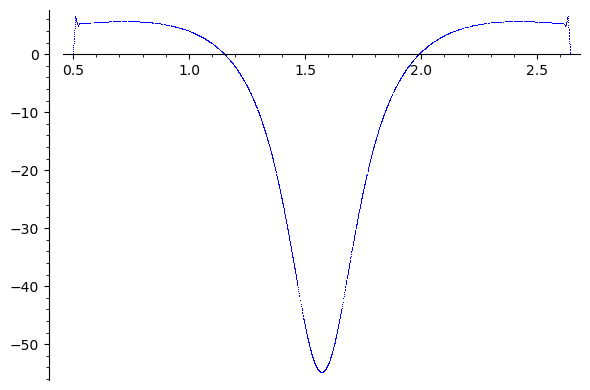

In [257]:
show(plot(m, srange))
show(plot(h, srange))
show(plot(K, srange, marker=",", linestyle=""))

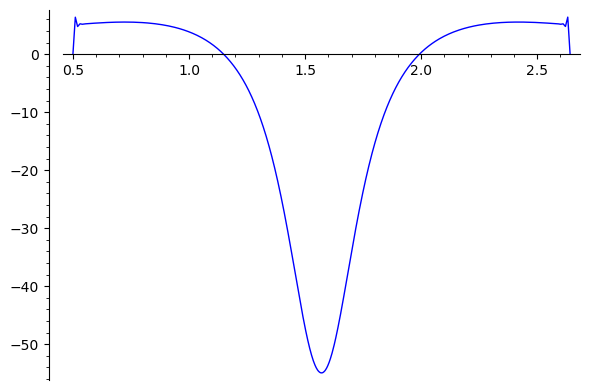

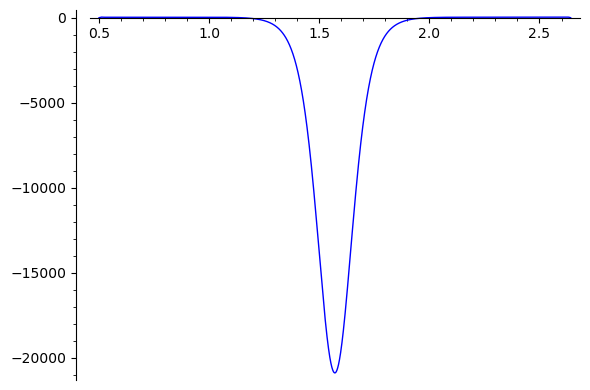

In [258]:
def R11(rho): return R(rho)[0][0]
def R22(rho): return R(rho)[1][1]
show(plot(R11, srange))
show(plot(R22, srange))

In [ ]:
dt = 0.000000001
steps = 50
space, dt = np.linspace(0, dt, 2, retstep=True)
print(dt)

h_ = h
m_ = m

plots = []

for i in range(12):
    R = hm_to_ricci_tensor(h_, m_)
    def R11(rho): return R(rho)[0][0]
    def R22(rho): return R(rho)[1][1]

    for z in np.linspace(eps, pi-eps):
        print(f"rho: {z}, R11: {R11(z)}, R22: {R22(z)}")
    
    h_ = spline([(rho, h_rho_ - 2*R11(rho)*dt) for rho, h_rho_ in h_.list()])
    m_ = spline([(rho, m_rho_ - 2*R22(rho)*dt) for rho, m_rho_ in m_.list()])
    print(m_.list())
    x, y = xy_splines_from_hm(h_, m_, srange, eps=eps)
    
    
    
    plots.append(parametric_plot((x, y), (eps, pi-eps)))
    
animate(plots)

1e-09
rho: 0.5, R11: 0.0, R22: 0.0
rho: 0.5437059725222406, R11: 5.177289582028966, R22: 27.00224254949778
rho: 0.5874119450444814, R11: 5.3244384547102195, R22: 25.939704070759518
rho: 0.6311179175667221, R11: 5.431183796719546, R22: 25.26596335041777
rho: 0.6748238900889627, R11: 5.502764020486984, R22: 24.972826856542305
rho: 0.7185298626112033, R11: 5.5324025281362506, R22: 25.01672476157643
rho: 0.7622358351334441, R11: 5.510334899164096, R22: 25.358499476186648
rho: 0.8059418076556848, R11: 5.4242747909451605, R22: 25.956121637966806
rho: 0.8496477801779254, R11: 5.26251342504781, R22: 26.76661905939033
rho: 0.893353752700166, R11: 5.0076353873394925, R22: 27.69544045385557
rho: 0.9370597252224068, R11: 4.637821347299172, R22: 28.56004695024536
rho: 0.9807656977446475, R11: 4.127281986432016, R22: 29.013049182642934
rho: 1.0244716702668881, R11: 3.4387800680668126, R22: 28.33070389511738
rho: 1.0681776427891287, R11: 2.5237102241674, R22: 25.060230233006
rho: 1.1118836153113696, 

rho: 0.5, R11: -3.046315616246128e-06, R22: -1.7405371204920457e-05
rho: 0.5437059725222406, R11: 5.177791473048268, R22: 27.004883600447656
rho: 0.5874119450444814, R11: 5.32444753349643, R22: 25.939768798622314
rho: 0.6311179175667221, R11: 5.431190640510526, R22: 25.266013829784118
rho: 0.6748238900889627, R11: 5.5027701678805165, R22: 24.972872562835473
rho: 0.7185298626112033, R11: 5.532408403823191, R22: 25.01676914252068
rho: 0.7622358351334441, R11: 5.5103408146181465, R22: 25.358545294238876
rho: 0.8059418076556848, R11: 5.424280936290642, R22: 25.956171235627494
rho: 0.8496477801779254, R11: 5.262519782323423, R22: 26.766674106550077
rho: 0.893353752700166, R11: 5.007641441782494, R22: 27.695500226246544
rho: 0.9370597252224068, R11: 4.637825270956975, R22: 28.56010205091568
rho: 0.9807656977446475, R11: 4.127278546830211, R22: 29.013061229680698
rho: 1.0244716702668881, R11: 3.4387546516412626, R22: 28.33053476361135
rho: 1.0681776427891287, R11: 2.523621904953696, R22: 25.0

[(0.5, 0.175021582727713), (0.510054425603708, 0.179110360097843), (0.5201088512074159, 0.183061080132733), (0.5301632768111239, 0.186863608601517), (0.5402177024148318, 0.190508928489136), (0.5502721280185398, 0.193988086391827), (0.5603265536222477, 0.197292501422199), (0.5703809792259557, 0.200413923145430), (0.5804354048296636, 0.203344479627718), (0.5904898304333716, 0.206076701579410), (0.6005442560370795, 0.208603551894479), (0.6105986816407875, 0.210918452803125), (0.6206531072444954, 0.213015312467642), (0.6307075328482034, 0.214888550353677), (0.6407619584519113, 0.216533121359921), (0.6508163840556193, 0.217944538521399), (0.6608708096593272, 0.219118894148505), (0.6709252352630352, 0.220052879256072), (0.6809796608667431, 0.220743801144490), (0.6910340864704511, 0.221189598999869), (0.701088512074159, 0.221388857387198), (0.711142937677867, 0.221340817518150), (0.7211973632815749, 0.221045386183968), (0.7312517888852829, 0.220503142253521), (0.7413062144889908, 0.2197153406

rho: 0.5, R11: -9.112277355162478e-06, R22: -5.206373530129397e-05
rho: 0.5437059725222406, R11: 5.178769781467108, R22: 27.010032876165912
rho: 0.5874119450444814, R11: 5.324465624402881, R22: 25.9398979301371
rho: 0.6311179175667221, R11: 5.431204330723619, R22: 25.26611480108668
rho: 0.6748238900889627, R11: 5.502782462796305, R22: 24.972963976294157
rho: 0.7185298626112033, R11: 5.532420155304511, R22: 25.016857905174223
rho: 0.7622358351334441, R11: 5.510352645629186, R22: 25.358636931114063
rho: 0.8059418076556848, R11: 5.424293227082621, R22: 25.95627043177374
rho: 0.8496477801779254, R11: 5.262532496945213, R22: 26.76678420164259
rho: 0.893353752700166, R11: 5.007653550547275, R22: 27.695619770861764
rho: 0.9370597252224068, R11: 4.63783311731865, R22: 28.56021224691205
rho: 0.9807656977446475, R11: 4.127271663222662, R22: 29.013085292926824
rho: 1.0244716702668881, R11: 3.4387037997670538, R22: 28.330196341708255
rho: 1.0681776427891287, R11: 2.5234451815838947, R22: 25.057711

In [ ]:
def K(y, rho):
    return y.derivative(rho, order=2)/y(rho)

steps = 100
t_space, dt = np.linspace(0, 1, steps, retstep=True)
plots = []
for t in t_space:
    h = spline([(rho, h_rho_ - 2*K(y, rho)*dt) for rho, h_rho_ in h.list()])
    m = spline([(rho, m_rho_ - 2*K(y, rho)*dt) for rho, m_rho_ in m.list()])
    print(h.list())
    x, y = xy_splines_from_hm(h, m, srange)
    plots.append([parametric_plot((x, y), (y.list()[0][0], y.list()[-1][0]))])
    
a = animate(plots)
a.show()